<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.columns


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#The data contain five unique years. Later the test data will contain 2010 and 
#the other data will go to training data
house.YrSold.unique()

array([2008, 2007, 2006, 2009, 2010])

In [6]:
house.shape


(1460, 81)

In [7]:
#there are 5types of houses were present
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [8]:
#The non residential houses were removed from the data
house=house[house.MSZoning != 'FV']
house=house[house.MSZoning != 'C (all)']

In [9]:
house.MSZoning.value_counts()

RL    1151
RM     218
RH      16
Name: MSZoning, dtype: int64

In [10]:
house.shape #About 75 rows were removed which belong to non-residential type of MSZoning

(1385, 81)

object     43
int64      35
float64     3
dtype: int64


Text(0.5,1,'Data Type Distribution')

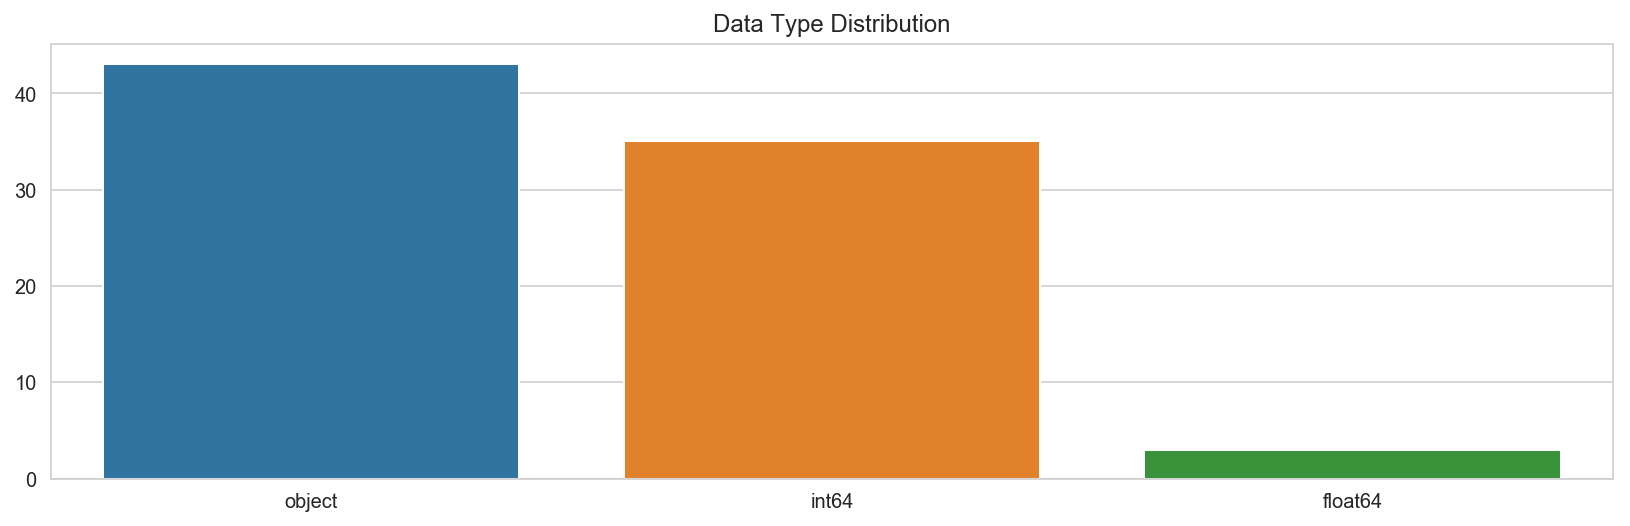

In [11]:
#Datatypes and its distribution

house_types = house.dtypes.value_counts()
print(house_types)

plt.figure(figsize = (14,4))
sns.barplot(x = house_types.index, y = house_types.values)
plt.title("Data Type Distribution")


There are 38 integer and float data type columns which can be used for predicting the target variable and 43 object data type columns which we can use to identify relationship between the feature. However, in order to use these columns for our Machine Learning algorithms we need to Encode them later in our Data Preprocessing stage.

In [12]:
num_col = house.select_dtypes(include=("float64", "int64"))
cat_col = house.select_dtypes(include=("object"))

Checking for the missing values in both categorical and numerical columns of the data

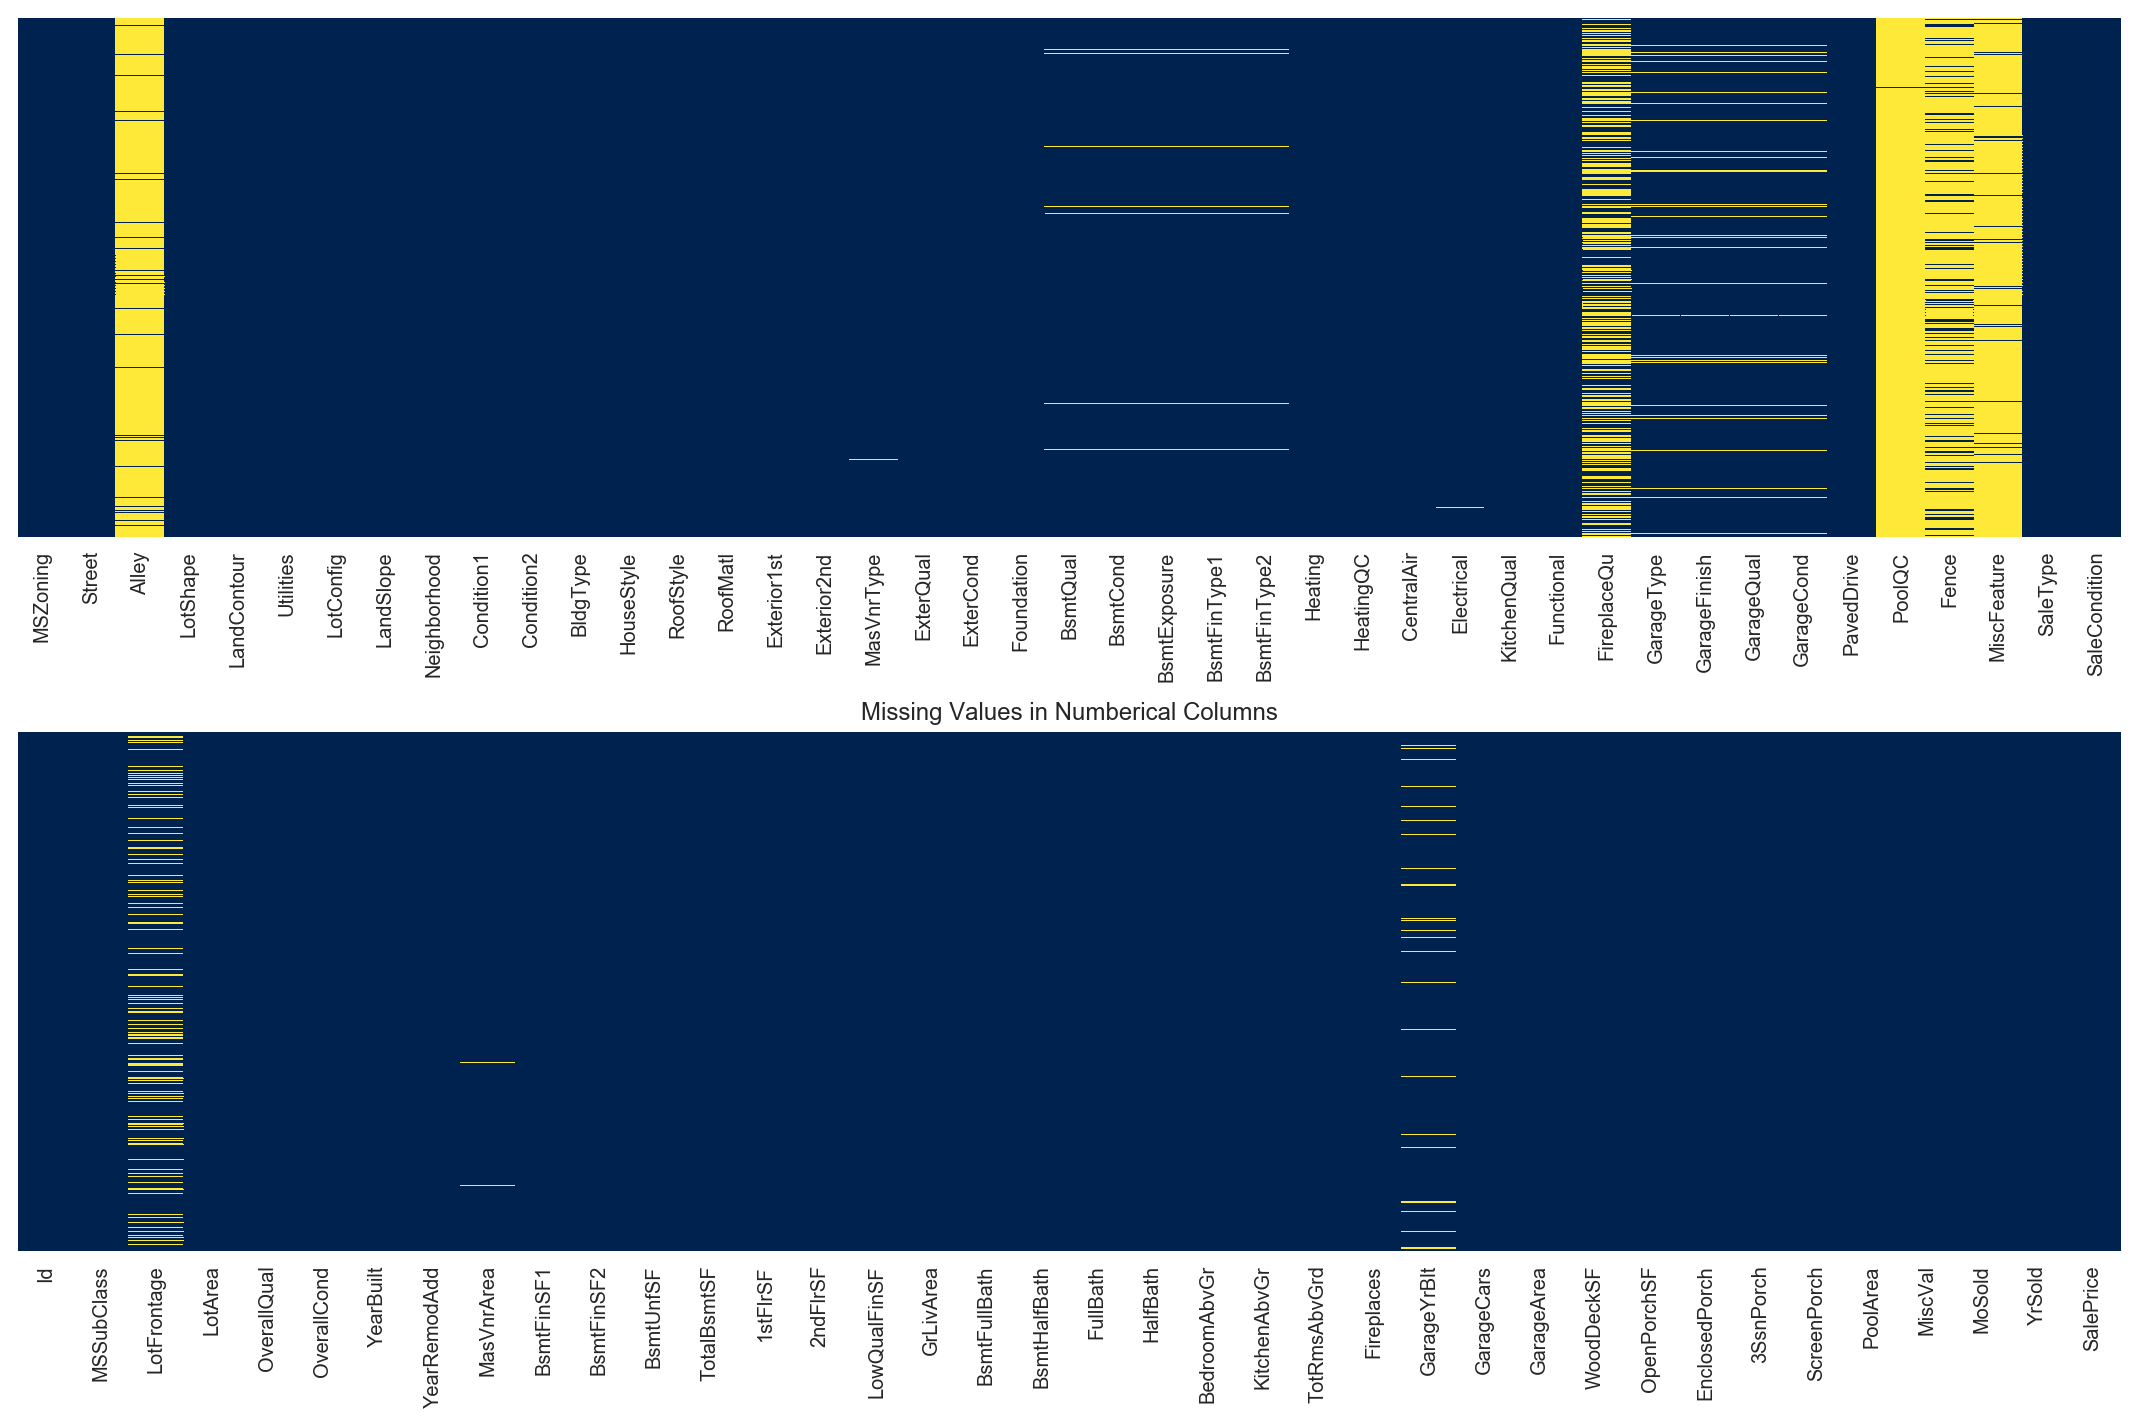

In [13]:
fig, (ax1, ax2) =plt.subplots(nrows=2, ncols=1, figsize = (15,10))

sns.heatmap(cat_col.isnull(), cbar = False, annot = False, cmap ="cividis", yticklabels=False, ax=ax1)
plt.title("Missing Values in Categorical Columns")
sns.heatmap(num_col.isnull(), cbar = False, annot = False, cmap ="cividis", yticklabels=False)
plt.title("Missing Values in Numberical Columns")
plt.tight_layout()

In [14]:
#missing data in Total and percent
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1378,0.994946
MiscFeature,1333,0.962455
Alley,1320,0.953069
Fence,1108,0.800000
FireplaceQu,641,0.462816
LotFrontage,251,0.181227
GarageCond,79,0.057040
GarageType,79,0.057040
GarageYrBlt,79,0.057040
GarageFinish,79,0.057040


In [15]:
#As 'PoolQC', 'MiscFeature', 'Alley' columns have more than 90% missing data. 
#we can drop those columns from our dataframe 
to_drop=['PoolQC', 'MiscFeature', 'Alley']
house.drop(to_drop,axis=1,inplace=True)

### Imputing the missing values

In [16]:
#Fence : data description says NA means "no fence"

house["Fence"] = house["Fence"].fillna("None")

In [17]:
#FireplaceQu : data description says NA means "no fireplace"
house["FireplaceQu"] = house["FireplaceQu"].fillna("None")

In [18]:
#LotFrontage : Since the area of each street connected to the house property most 
#likely have a similar area to other houses in its neighborhood, 
#we can fill in missing values by the median LotFrontage of the neighborhood.

house["LotFrontage"] = house.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [19]:
#GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    house[col] = house[col].fillna('None')

In [20]:
#GarageYrBlt, GarageArea and GarageCars : 
#Replacing missing data with 0 (Since No garage = no cars in such garage.)

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    house[col] = house[col].fillna(0)

In [21]:
#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : 
#missing values are likely zero for having no basement

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    house[col] = house[col].fillna(0)

In [22]:
#replace 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2' with none
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    house[col] = house[col].fillna('None')

In [23]:
#MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. 
#We can fill 0 for the area and None for the type.

house["MasVnrType"] = house["MasVnrType"].fillna("None")
house["MasVnrArea"] = house["MasVnrArea"].fillna(0)

In [24]:
#For Utilities column lets check for the values

house.Utilities.value_counts()

AllPub    1384
NoSeWa       1
Name: Utilities, dtype: int64

In [25]:
#Utilities : For this categorical feature all records are "AllPub", 
#except for one "NoSeWa" 
#this feature won't help in predictive modelling. We can then safely remove it.

house = house.drop(['Utilities'], axis=1)

In [26]:
#For Functional column lets check the values 

house.Functional.value_counts()

Typ     1285
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [27]:
#Since most of the columns are Typ, lets fill the null values with the max values
house["Functional"] = house["Functional"].fillna("Typ")

In [28]:
house.Electrical.value_counts()

SBrkr    1263
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [29]:
#Since most of the columns are SBrkr, lets fill the null values with the max values
house['Electrical'] = house['Electrical'].fillna(house['Electrical'].mode()[0])

In [30]:
#Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. 
#so substitute with the most common string

house['Exterior1st'] = house['Exterior1st'].fillna(house['Exterior1st'].mode()[0])
house['Exterior2nd'] = house['Exterior2nd'].fillna(house['Exterior2nd'].mode()[0])

In [31]:
#for Saletype

house['SaleType'] = house['SaleType'].fillna(house['SaleType'].mode()[0])

In [32]:
#for MSSubClass

house['MSSubClass'] = house['MSSubClass'].fillna("None")

In [33]:
#missing data in Total and percent
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
SalePrice,0,0.0
Foundation,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
MasVnrType,0,0.0
MasVnrArea,0,0.0
ExterQual,0,0.0
ExterCond,0,0.0
BsmtQual,0,0.0


In [34]:
#It remains no missing value

In [35]:
house.shape

(1385, 77)

### Let do some analysis about the taget variable SalePrice

In [36]:
house['SalePrice'].describe()

count      1385.000000
mean     180136.283032
std       79906.363281
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212900.000000
max      755000.000000
Name: SalePrice, dtype: float64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


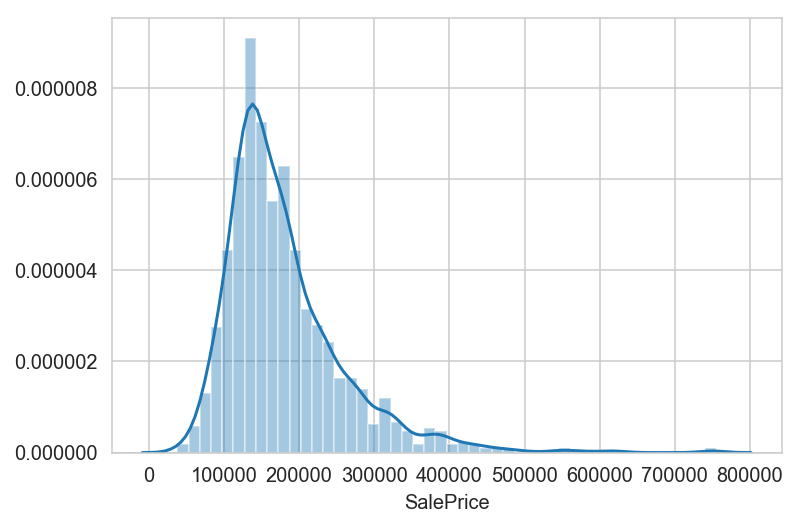

In [37]:
sns.distplot(house['SalePrice']);

In [38]:
#The above graph shows deviation from the normal distribution. It has positive skewness and show peakedness.

In [39]:
#skewness and kurtosis
print("Skewness: %f" % house['SalePrice'].skew())
print("Kurtosis: %f" % house['SalePrice'].kurt())

Skewness: 1.961336
Kurtosis: 6.793400


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


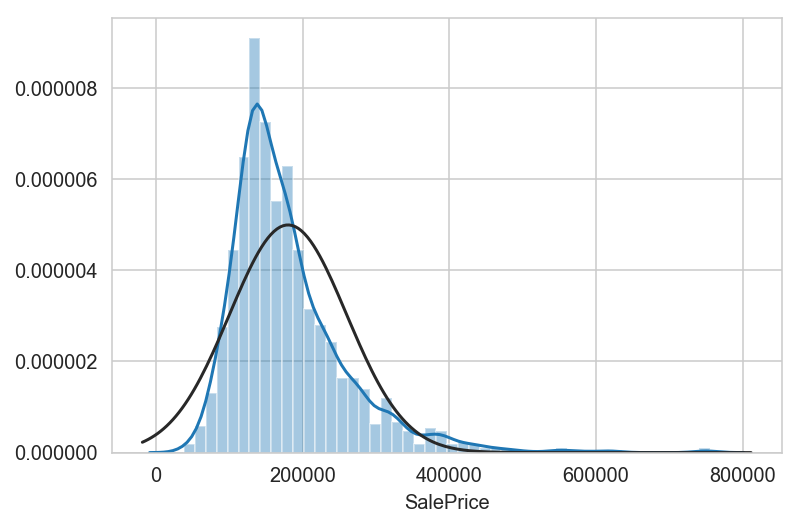

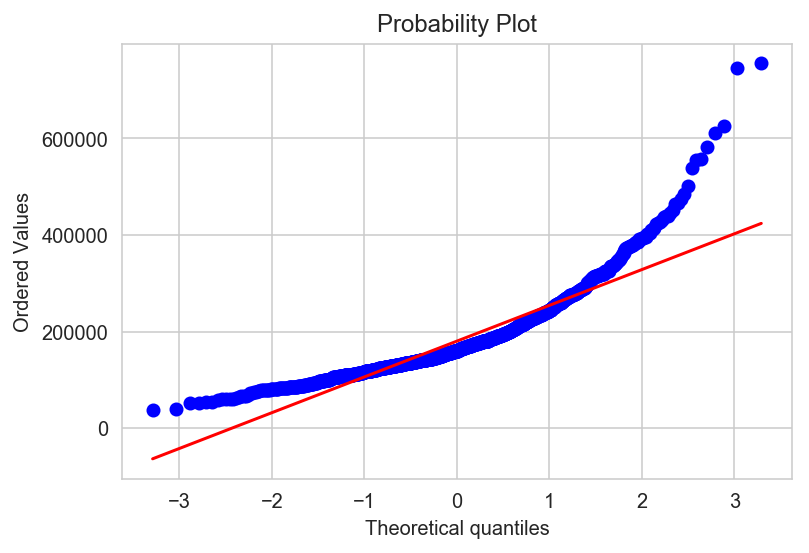

In [40]:
#histogram and normal probability plot
from scipy.stats import norm
sns.distplot(house['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['SalePrice'], plot=plt)


In [41]:
#The target variable is right skewed. As (linear) models love normally distributed data, 
#we need to transform this variable and make it more normally distributed.

In [42]:
#applying log transformation
house['SalePrice'] = np.log(house['SalePrice'])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


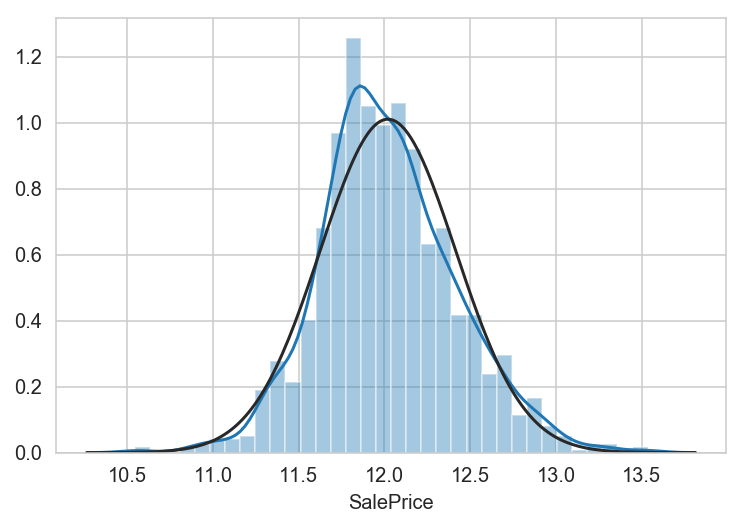

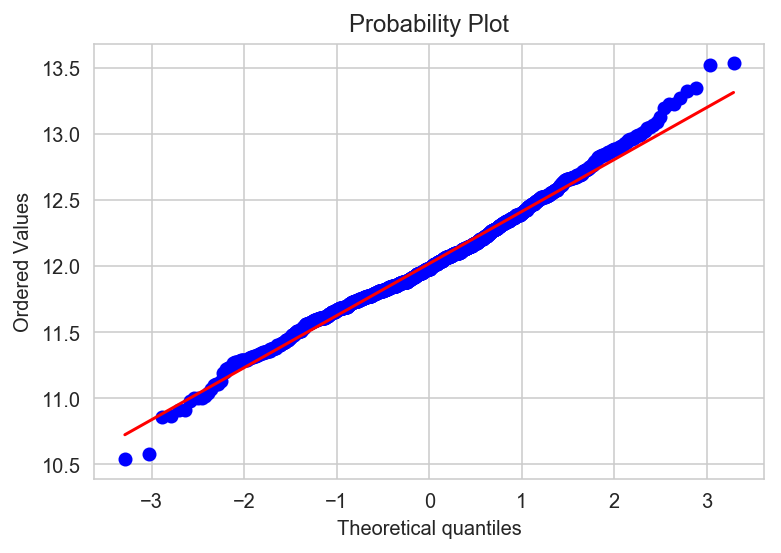

In [43]:
#transformed histogram and normal probability plot
sns.distplot(house['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['SalePrice'], plot=plt)

In [44]:
# SalePrice data transformation
house['SalePrice'] = np.log(house['SalePrice'])

#The skew seems now corrected and the data appears more normally distributed.

### Feature Engineering

In [45]:
#The TotalBSmtSF is eqaual to sum of ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'). 
#And therefore only TotalBSmtSF was used for analysis.

#The GrLivArea is equal to sum of ('1stFlrSF', '2ndFlrSF','LowQualFinSF'). 
#And therefore only GrLivArea is used for analysis.

#For Garage size, 
#I am using GarageArea and dropping the GarageCars(Size of garage in car capacity)

#Also dropping Id column which doesnot have influence on target value

#Creating another column totalSF by adding TotalBsmtSF and GrLivArea

house['TotalSF']=house.TotalBsmtSF+house.GrLivArea

to_drop=['Id','GrLivArea', 'TotalBsmtSF','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'GarageCars']
   
house.drop(to_drop, inplace=True, axis=1)


In [46]:
#  I am summing up the number of both full and half bathrooms 
#at basement and above ground to one term bath

house['Bath']=house.BsmtFullBath+house.BsmtHalfBath+house.FullBath+house.HalfBath


In [47]:
to_drop=['BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath']
house.drop(to_drop, inplace=True, axis=1)


In [48]:
# I am creating a new column which is outdoorSF by summing up 'WoodDeckSF', 'OpenPorchSF',
#'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea'

house['OutdoorSF']=house.WoodDeckSF+house.OpenPorchSF+house.EnclosedPorch+house['3SsnPorch']+house.ScreenPorch+house.PoolArea

In [49]:
to_drop=['WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
house.drop(to_drop, inplace=True, axis=1)

In [50]:
house.shape

(1385, 60)

In [51]:
#Transforming some numerical variables that are really categorical
house['MSSubClass'] = house['MSSubClass'].apply(str)

house['OverallCond'] = house['OverallCond'].astype(str)

house['OverallQual'] = house['OverallQual'].astype(str)

house['GarageYrBlt'] = house['GarageYrBlt'].astype(str)

house['YearRemodAdd'] = house['YearRemodAdd'].astype(str)

house['YearBuilt'] = house['YearBuilt'].astype(str)

house['YrSold'] = house['YrSold'].astype(str)

house['MoSold'] = house['MoSold'].astype(str)

In [52]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice', 'TotalSF', 'Bath', 'OutdoorSF'],
      dtype='object')

In [53]:
num_col1 = house.select_dtypes(include=("float64", "int64"))
cat_col1 = house.select_dtypes(include=("object"))

In [54]:
num_col1.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'MiscVal', 'SalePrice',
       'TotalSF', 'Bath', 'OutdoorSF'],
      dtype='object')

#### Checking the skewedness of the numerical variables



In [55]:

from scipy.stats import norm, skew
skewed_feats = num_col1.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
MiscVal,23.844175
LotArea,12.049140
KitchenAbvGr,4.389399
MasVnrArea,2.421240
LotFrontage,2.358232
TotalSF,1.784726
OutdoorSF,1.605951
TotRmsAbvGrd,0.687978
Fireplaces,0.628207
Bath,0.322830


In [56]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 13 skewed numerical features to Box Cox transform


In [57]:

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    house[feat] = boxcox1p(house[feat], lam)
    

In [58]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,Bath,OutdoorSF
0,60,RL,5.831328,19.212182,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,8.059126,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,1.540963,0.730463,Gd,2.602594,Typ,0.000000,None,Attchd,2003.0,RFn,10.506271,TA,TA,Y,None,0.0,2,2008,WD,Normal,1.380041,14.976591,1.820334,5.714669
1,20,RL,6.221214,19.712205,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,1.540963,0.730463,TA,2.259674,Typ,0.730463,TA,Attchd,1976.0,RFn,10.062098,TA,TA,Y,None,0.0,5,2007,WD,Normal,1.376114,14.923100,1.540963,9.010206
2,60,RL,5.914940,20.347241,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,7.646538,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,1.540963,0.730463,Gd,2.259674,Typ,0.730463,TA,Attchd,2001.0,RFn,10.775536,TA,TA,Y,None,0.0,9,2008,WD,Normal,1.381987,15.149678,1.820334,5.053371
3,70,RL,5.684507,19.691553,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,1.540963,0.730463,Gd,2.440268,Typ,0.730463,Gd,Detchd,1998.0,Unf,10.918253,TA,TA,Y,None,0.0,2,2006,WD,Abnorml,1.368611,14.857121,1.194318,9.080098
4,60,RL,6.314735,21.325160,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,9.391827,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,1.820334,0.730463,Gd,2.750250,Typ,0.730463,TA,Attchd,2000.0,RFn,11.627708,TA,TA,Y,None,0.0,12,2008,WD,Normal,1.385098,15.852312,1.820334,8.831514


In [59]:
house.shape

(1385, 60)

In [60]:
fixed_features=['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'YearBuilt','Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional',
       'GarageType', 'GarageYrBlt', 'PavedDrive', 'Fence', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageArea',
       'TotalSF', 'Bath', 'OutdoorSF']
      

In [61]:
renewable_features=['OverallQual', 'OverallCond','YearRemodAdd','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                    'MasVnrType', 'ExterQual', 'ExterCond','Heating','HeatingQC', 'CentralAir', 'Electrical', 
                    'KitchenQual','FireplaceQu','GarageQual','GarageFinish', 'GarageCond','Fence', 'MiscVal']

In [62]:
#fixed_features = pd.get_dummies(house[fixed_features])
#print(fixed_features.shape)

In [63]:
#fixed_features.head()

In [64]:
house.shape

(1385, 60)

In [65]:
X=house[fixed_features]
X.shape

(1385, 39)

In [66]:
#YrSold was changed to int to split the train test split
house['YrSold'] = house['YrSold'].astype(int)

In [67]:
#Train data with data from yrSold 2006,2007 and 2008. Test data is with data from YrSold 2010

year_column = 'YrSold'


X_train=house[fixed_features][house[year_column].isin([2008, 2006, 2007])]
X_test=house[fixed_features][house[year_column] == 2010]

y_train=house['SalePrice'][house[year_column].isin([2008, 2006, 2007])]
y_test=house['SalePrice'][house[year_column] == 2010]


In [68]:
X_train.shape

(900, 39)

In [69]:
y_train.shape

(900,)

In [70]:
X_test.shape

(164, 39)

In [71]:
house['YrSold'] = house['YrSold'].astype(str) #changed to str to consider as categorical value


X_train = pd.get_dummies(X_train,drop_first=True)
print(X_train.shape)

(900, 360)


In [72]:
cols=X_train.columns
cols

Index(['YrSold', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'TotalSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=360)

In [73]:
X_test = pd.get_dummies(X_test,drop_first=True)
print(X_test.shape)

(164, 263)


### Creating Test and Train Data

In [74]:
from sklearn.preprocessing import StandardScaler


ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test=ss.fit_transform(X_test)

In [75]:
Xs_train.shape

(900, 360)

In [76]:
y_train.shape

(900,)

In [87]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn import metrics
import statsmodels.api as sm

In [88]:
lm = LinearRegression()

In [89]:
lm.fit(Xs_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [90]:
predictions = lm.predict( X_test)

ValueError: shapes (164,263) and (360,) not aligned: 263 (dim 1) != 360 (dim 0)

In [77]:
import statsmodels.api as sm

model = sm.OLS(y_train, Xs_train).fit()

In [86]:
y_pred = model.predict(X_test, transform=True)

ValueError: shapes (164,263) and (360,) not aligned: 263 (dim 1) != 360 (dim 0)

### Feature Selction using Recursive Feature Elimination (RFE)

### Cross-validate the lasso  R2  with the optimal alpha

### coefficients for variables in the lasso

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [79]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [80]:
# A: